## Phase 2 Project Submission

* **Students names:** Angella Bor | Jackline Njuguna | Vitelis Siocha | Mwenda Mugambi
* **Student pace:**  Part time 

# Project Overview

In this notebook, we'll conduct a comprehensive analysis of house sales data in a northwestern county using multiple linear regression modeling. Our goal is to gain insights into the factors that affect house prices and develop a predictive model that can estimate the value of homes based on various features.

## Stakeholder 

For this project, we will complete it on behalf of our primary stakeholder "Weichert Realtors." Weichert Realtors specializes in assisting homeowners in buying and selling homes in the northwestern county. 

## Business Problem

**Business Problem:** 
Weichert Realtors needs to provide valuable advice to homeowners regarding how home renovations may impact the estimated value of their homes and by what amount.

**Objective:**
- Develop a predictive model that can estimate the effect of different home renovations on the estimated home value.
- Provide actionable insights to homeowners about which renovations are likely to yield the highest return on investment (ROI).

**Why is this problem important?**
Homeowners frequently invest in home renovations to improve their living conditions and increase the value of their properties. However, they often lack guidance on which renovations are the most cost-effective in terms of increasing property value. By addressing this problem, Weichert Realtors can offer valuable guidance to homeowners, strengthen their relationships with clients, and potentially increase their business.

**Questions to answer:**
1. Does increasing the number of bedrooms and bathrooms lead to higher house prices?
2. How does the square footage of the living area affect house prices?
3. How Does the Overall Condition of a Property Influence Its Price?


# Exploratory Data Analysis

In this section, We'll be going through the data sets we have to understand the structure and determine the ones we'll be using for this project.
 * We start by importing the libraries and the datasets that will be necessary for the process.


In [1]:
#Importing the necessary Libraries.
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing the data set
data = pd.read_csv("data/kc_house_data.csv") 
data.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4344,3856904560,11/25/2014,562000.0,4,1.75,2060,4080,1.5,NO,NONE,...,7 Average,1460,600.0,1922,1996.0,98105,47.6698,-122.325,1620,4080
19449,6431000206,5/8/2014,835000.0,4,2.00,1910,6960,1.5,NaN,NONE,...,8 Good,1910,?,1941,0.0,98103,47.6893,-122.348,1360,3300
20753,5244801550,9/16/2014,1110000.0,4,3.00,2770,2650,2.0,NO,NONE,...,9 Better,2180,590.0,2014,0.0,98109,47.6435,-122.354,1820,2960
10503,3205200240,4/30/2015,420000.0,4,1.75,1340,8400,1.0,NO,NONE,...,7 Average,1340,0.0,1967,0.0,98056,47.5382,-122.173,1980,8400
11326,9264911550,10/22/2014,310000.0,3,3.25,3130,9302,2.0,NO,NONE,...,8 Good,2190,940.0,1987,0.0,98023,47.3078,-122.338,2350,7949
17682,7611200195,2/20/2015,709000.0,3,2.00,2360,18000,1.0,NO,NONE,...,8 Good,2180,180.0,1951,NaN,98177,47.7133,-122.367,2600,17300
14715,7202340720,5/20/2014,620000.0,3,2.50,2480,9041,2.0,NO,NONE,...,7 Average,2480,0.0,2004,0.0,98053,47.6797,-122.035,2480,6500
17494,3761100257,7/14/2014,1220000.0,3,3.00,4560,16339,2.0,NO,AVERAGE,...,10 Very Good,4040,520.0,2001,0.0,98034,47.7024,-122.243,2620,11561
7237,3438500168,5/7/2015,325000.0,3,1.50,1060,7488,1.0,NO,NONE,...,7 Average,1060,0.0,1977,0.0,98106,47.5549,-122.356,1300,6780
14174,7631200085,5/12/2014,947500.0,3,2.75,2980,27144,1.5,YES,AVERAGE,...,8 Good,2180,800.0,1917,NaN,98166,47.4522,-122.378,1890,12514


## Data Understanding

In [3]:
# Checking the shape of our data
data.shape

(21597, 21)

We have (21 columns) and (21597) rows

In [4]:
# Checking the columns in our data frame
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
* `view` - Quality of view from house
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
* `grade` - Overall grade of the house. Related to the construction and design of the house.
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

We start by getting a quick overview of our dataset using data.info() which provides a concise summary of essential information about the DataFrame.

In [5]:
# getting a quick overview of our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
# Checking for duplicate entries
data.duplicated().sum()

0

* From the output, we can see that several columns have missing values, such as 'waterfront', 'view' and 'yr_renovated' but there are no duplicate entries.

## Data Processing

## Filling Null Values

We now check the entries in these columns and to confirm they have the correct data type entries so that we can choose the best way to handle the missing values.

#### "Waterfront" Column

In [7]:
# Checking see the count of each data value in the Waterfront column
print(data["waterfront"].value_counts())

# Checking for missing values
print(f"Total Missing values:{data['waterfront'].isna().sum()}")

NO     19075
YES      146
Name: waterfront, dtype: int64
Total Missing values:2376


The "waterfront" column contains data denoting whether a home is waterfront or not. This data can be later be converted to binary data, indicating whether a home is waterfront (1) or not (0)

With the column having missing values. We assume that missing values in this column implies that the properties are not Waterfronts, Homeowners with waterfront homes are more likely to provide this information as compared to those without, who might leave the field blank during the data collection.

In [8]:
# Filling the missing values with (NO)
data["waterfront"] = data["waterfront"].fillna("NO")

# Confirming our changes worked
print(f"Total Missing values:{data['waterfront'].isna().sum()}")

Total Missing values:0


#### "View" Column

In [9]:
# Checking see the count of each data value in the View column
print(data["view"].value_counts())

# Checking for missing values
print(f"Total Missing values:{data['view'].isna().sum()}")

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64
Total Missing values:63


We see the range of view ratings are from from average to excellent. 
Majority of the homes are categorized as having no view, specifically labeled as "NONE."

To deal with the missing values in this column, we'll consider that If a home doesn't possess a significant view, it's likely that respondents skipped or left this section blank. 
With this logic, tt would be resonable for us to fill the missing values with "NONE"

In [10]:
# Filling the missing values with (NONE)
data["view"] = data["view"].fillna("NONE")

In [11]:
print(data["view"].value_counts())
# Confirming our changes worked
print(f"Total Missing values:{data['view'].isna().sum()}")

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64
Total Missing values:0


#### "yr_renovated" Column

In [12]:
# Checking see the count of each data value in the "yr_renovated" column
print(data["yr_renovated"].value_counts())

# Checking for missing values
print(f"Total Missing values:{data['yr_renovated'].isna().sum()}")

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64
Total Missing values:3842


This column represents the year of home renovation.

The data represents the year as a numerical value. In this context, zero implies that the home has never been renovated. 
Since zero is the most popular value, we can conclude that the missing values signifies that the home was not renovated. This makes it  reasonable for us to go ahead with this assumption to deal with the missing values.

In [13]:
# Filling the missing values with (0)
data["yr_renovated"] = data["yr_renovated"].fillna(0)

In [14]:
# Confirming our changes worked
print(f"Total Missing values:{data['yr_renovated'].isna().sum()}")

Total Missing values:0


In [15]:
# Getting a quick overview of our data to confirm we no longer have missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  object 
 9   view           21597 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

* Great now that we can see we no longer have any missing values.

Next we can get a quick overview of the distribution and central tendency of the data to get more nsights into the dataset's characteristics

In [16]:
# Getting summary statistics of our dataset
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


From the result we can see that
* Home prices range from $ 78,000 -  $ 7,700,000
* The mean house price in the dataset is approximately $540,296.
* Most houses have between 3 and 4 bedrooms on average (mean of approximately 3.37)
* There is also a maximum of 33 bedrooms-(This could be an outlier or a data entry error.)
* The average number of bathrooms is approximately 2.12, with a range from 0.5 to 8 bathrooms per house.
* The houses in the dataset were built over a wide time span, with a mean construction year of around 1971, suggesting both older and newer properties.
* Most houses have 1.494 floors on average, with a minimum of 1 floor and a maximum of 3.5 floors.
* The 'yr_renovated' column indicates that some houses have been renovated, with the maximum renovation year being 2015. However, a large number of houses have no recorded renovations.

In order for us to confirm if 33 bedrooms is an outlier, We can use a boxplot.

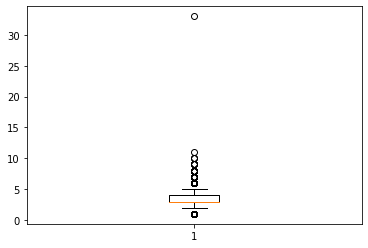

In [17]:
# Plotting a boxplot
plt.boxplot(data["bedrooms"]);

In deed we can see that it is an outlier.
* In this case, it would be safe to assume that this was a data enty error. 33 instead of 3. We can go ahead to replace 33 with 3. 

In [18]:
# replaces 33 with 3 
data["bedrooms"] = data["bedrooms"].replace(33, 3) 

# Checking to see if it has been changed
data["bedrooms"].max()

11

## Dropping unnecessary columns
Based on the questions we want to answer, the 'id', 'date', 'zipcode', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long' columns will not be essensial in our analysis. We can go ahead and drop them.

In [19]:
# Dropping the columns and assigning it to a new df
new_data = data.drop(['id','date','zipcode', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long'], axis=1)
new_data.head(20)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated
0,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,7 Average,1955,0.0
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,1951,1991.0
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,1933,0.0
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1965,0.0
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1987,0.0
5,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,Average,11 Excellent,2001,0.0
6,257500.0,3,2.25,1715,6819,2.0,NO,NONE,Average,7 Average,1995,0.0
7,291850.0,3,1.50,1060,9711,1.0,NO,NONE,Average,7 Average,1963,0.0
8,229500.0,3,1.00,1780,7470,1.0,NO,NONE,Average,7 Average,1960,0.0
9,323000.0,3,2.50,1890,6560,2.0,NO,NONE,Average,7 Average,2003,0.0


## Data Analysis and Visualization
Now that we've dropped the unnecessary we can visualize the relationships between various features and the house prices.

* We start by looking at the distribution of the house prices.

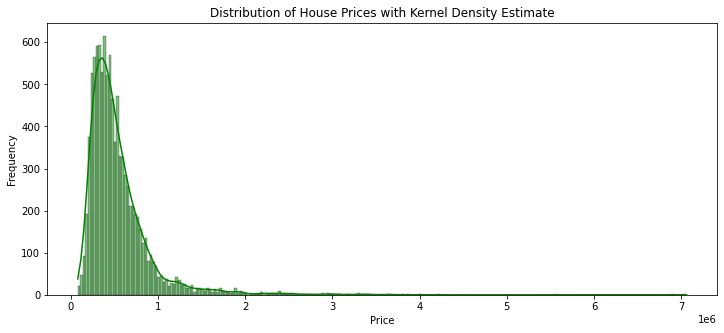

In [29]:
# Create a distribution plot with a distribution curve
plt.figure(figsize=(12, 5))
sns.histplot(new_data.sample(10000), x="price", kde=True, color='green')

# Set labels and title
plt.xlabel("Price")
plt.ylabel('Frequency')
plt.title("Distribution of House Prices with Kernel Density Estimate");

* Next we go on to Plotting so check the correlation of the other features with Price.

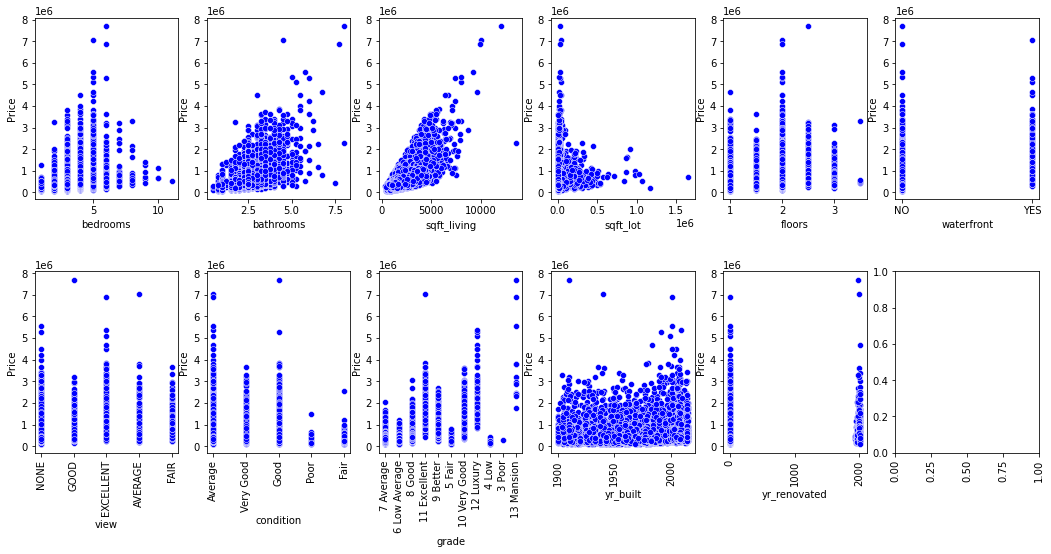

In [30]:
fig, axes = plt.subplots(2, 6, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4)  # Adjusting the vertical spacing

# Iterate and plot subplots
for xcol, ax in zip(new_data.columns[1:], [x for v in axes for x in v]):
    sns.scatterplot(data=new_data, x=xcol, y="price", ax=ax,color="blue")
    ax.set_xlabel(xcol)
    ax.set_ylabel("Price")

# Rotate x-axis labels if needed
for ax in axes[-1, :]:
    ax.tick_params(axis="x", labelrotation=90);

* Now to visualize the correlation between different features. 

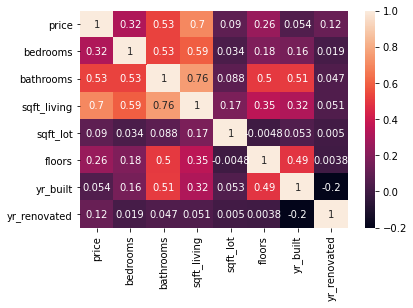

In [22]:
# Creating a heatmap to visualize the feature correlations
sns.heatmap(new_data.corr(), annot=True);

### Findings / More Analysis (Edit this cell)